# LSTM
**This is the main notebook for the LSTM model.** A secondary notebook *LSTM_tuning.ipynb* has been created for tuning the hyperparameters as the process takes very long. This notebook shows the different variants of LSTM models we trained for three time offsets: ```t+1```, ```t+5``` and ```t+30```, as well as another three variants trained for three stocks representing three trends of stock prices.

The sections are as follows:
1. [Importing Data](#1.-Importing-Data): Data import and visualization
2. [Helper Functions](#2.-Helper-Functions)
3. [Regression Models for Diff Time Periods](#3.-Regression-Models-for-Diff-Time-Periods): LSTM models trained for different time offsets ```t+1```, ```t+5``` and ```t+30```
4. [Regression Models for Diff Time Periods (Stationary Data)](#4.-Regression-Model-for-Diff-Time-Periods-(Stationary)): LSTM models trained for different time offsets with stationary data
5. [Prediction of Up/Down Trend](#5.-Prediction-of-Up/Down-Trend): Classification prediction of up/down trend
6. [Expected Gain](#6.-Expected-Gain): Estimate of profits
7. [Different Stocks](#7.-Different-Stocks): Performance on different stock price patterns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time
from tensorflow import keras as keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Importing Data
We first import the data and observe the stock price trend. Since there are no invalid values, all the data will be used in training. Columns ```t+1```, ```t+5``` and ```t+30``` are appended to define the close values with a 1, 5 and 30 day offset. These columns will be helpful later in computing the "up/down" trends like in our presentation.

In [2]:
stock = 'aapl' # Apple
df = pd.read_csv('../Data/Stocks/%s.us.txt' % stock, index_col=0)
df.drop('OpenInt', axis=1, inplace=True)
print(df.shape)
df.head()

(8364, 5)


,Open,High,Low,Close,Volume
Date,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062


In [3]:
# Add columns for offsets
df['t+1'] = np.r_[df['Close'].values[1:], np.nan]
df['t+5'] = np.r_[df['Close'].values[5:], np.empty((5,))*np.nan]
df['t+30'] = np.r_[df['Close'].values[30:], np.empty((30,))*np.nan]
df.head()

,Open,High,Low,Close,Volume,t+1,t+5,t+30
Date,,,,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0.42134,0.44566,0.40853
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0.42902,0.45718,0.40593
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0.41618,0.44052,0.41491
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0.43927,0.43157,0.41874
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0.44566,0.43286,0.40339


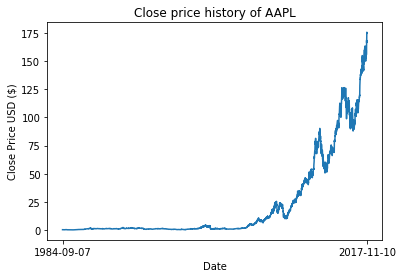

In [4]:
# Visualize closing price history
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

# 2. Helper Functions
Helper functions are defined here.

In [5]:
# Set styles
# sb.set_style("darkgrid")
# plt.style.use("dark_background")

In [6]:
# Prepare data for autoregression with given timestep and offset (t+1/5/30)
# x has shape (num_samples, timestep)
def prepare_autoreg(data, timestep, offset):
    x,y = [],[]
    for i in range(timestep,len(data)):
        if i+offset-1 < len(data):
            x.append(data[i-timestep:i])
            y.append(data[i+offset-1])
        else:
            break
    return np.array(x), np.array(y)

In [7]:
# Split data into training, validation and test datasets based on given split ratio and time offset
# Additional argument "stationary" added for splitting of stationary data
def train_val_test_split(data, timestep, split=[0.6,0.2], offset=1, stationary=False):
    
    # Split train, validation & test data
    length = len(data)+1 if stationary else len(data)
    train_split = int(length * split[0]) + (-1 if stationary else 0)
    val_split = int(length * (split[0]+split[1])) + (-1 if stationary else 0)
    train_data = data[ : train_split] 
    val_data = data[train_split-timestep-offset+1 : val_split] 
    test_data = data[val_split-timestep-offset+1 : ]

    # Normalization
    scaler = MinMaxScaler(feature_range=(0,1))
    train_data = scaler.fit_transform(np.array(train_data).reshape(-1,1)) # scaler fit to training data
    val_data = scaler.transform(np.array(val_data).reshape(-1,1))
    test_data = scaler.transform(np.array(test_data).reshape(-1,1))
        
    # Generate training and test dataset
    xtr, ytr = prepare_autoreg(train_data, timestep, offset)
    xval, yval = prepare_autoreg(val_data, timestep, offset)
    xts, yts = prepare_autoreg(test_data, timestep, offset)

    return (xtr, ytr, xval, yval, xts, yts), scaler

In [8]:
# Build LSTM model based on given timestep and number of nodes
# Architecture is determined from the "LSTM_tuning.ipynb"
def build_lstm(timestep, nodes):
    lstm = Sequential()
    lstm.add(LSTM(nodes, return_sequences=True, input_shape=(timestep,1)))
    lstm.add(LSTM(nodes))
    lstm.add(Dense(nodes))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm

In [9]:
# Returns RMSE and predicted target
# Additional arguments "show_loss" and "show_plot" to show loss over epochs or time series plot
def evaluate_lstm(data, model, scaler, **kwargs):
    
    # Define variables from arguments
    (xtr, ytr, xval, yval, xts, yts) = data
    show_loss = kwargs['show_loss'] if 'show_loss' in kwargs else 1 # show loss over epochs plot
    show_plot = kwargs['show_plot'] if 'show_plot' in kwargs else 1 # show time series plot
    stationary = kwargs['stationary'] if 'stationary' in kwargs else False # not stationary data by default
    
    # Check for missing args
    check_args = [k for k in ['actual_data','timestep','offset'] if k not in kwargs]
    if (show_plot or stationary) and len(check_args):
        raise Exception('The followings arguments are missing: %s' % ', '.join(check_args))
        return
    if show_loss and 'hist' not in kwargs:
        raise Exception('Please provide the model history handle (hist=handle) for plotting loss.')
        return
        
    # Prediction
    ytr_pred = model.predict(xtr)
    yval_pred = model.predict(xval)
    yts_pred = model.predict(xts)

    # Inverse transform all y values
    ytr_pred_itf = np.ravel(scaler.inverse_transform(ytr_pred))
    yval_pred_itf = np.ravel(scaler.inverse_transform(yval_pred))
    yts_pred_itf = np.ravel(scaler.inverse_transform(yts_pred))
    ytr_true = np.ravel(scaler.inverse_transform(ytr))
    yval_true = np.ravel(scaler.inverse_transform(yval))
    yts_true = np.ravel(scaler.inverse_transform(yts))
    
    # For stationary data, perform necessary inverse transformation
    if stationary:
        actual_data, timestep, offset = kwargs['actual_data'], kwargs['timestep'], kwargs['offset']
        str_end = timestep+offset-2 + len(ytr_pred_itf) + 1
        sval_end = str_end + len(yval_pred_itf)
        true_data = actual_data['Close'].values
        ytr_pred_itf = true_data[timestep+offset-2 : str_end] + np.r_[0,ytr_pred_itf]
        yval_pred_itf = true_data[str_end : sval_end] + yval_pred_itf
        yts_pred_itf = true_data[sval_end : -1] + yts_pred_itf
        ytr_true = true_data[timestep+offset-2 : str_end] + np.r_[0,ytr_true]
        yval_true = true_data[str_end : sval_end] + yval_true
        yts_true = true_data[sval_end : -1] + yts_true

    # Get RMSE
    rmse_tr = mean_squared_error(ytr_true, ytr_pred_itf, squared=False)
    rmse_val = mean_squared_error(yval_true, yval_pred_itf, squared=False)
    rmse_ts = mean_squared_error(yts_true, yts_pred_itf, squared=False)

    # Visualize loss
    if show_loss:
        hist = kwargs['hist']
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training', 'Validation'])
        plt.xlabel('Epochs')
        plt.title('Loss (MSE) over Epochs')
        plt.show()
        print('RMSE (Train):', rmse_tr)
        print('RMSE (Val):', rmse_val)

    # Visualize data
    if show_plot:
        # Define variables
        actual_data, timestep, offset = kwargs['actual_data'], kwargs['timestep'], kwargs['offset']
        title = kwargs['title'] if 'title' in kwargs else 'Predicted Close Values'
        suffix = ' (%s)' % kwargs['stock'].upper() if 'stock' in kwargs else ''
        save_fig = kwargs['save_fig'] if 'save_fig' in kwargs else False
        
        # Define params
        dates = actual_data.index.values
        ytr_end = ytr_pred_itf.shape[0] + timestep + offset-1
        yval_end = yval_pred_itf.shape[0] + ytr_end
    
        # Plot
        plt.figure(figsize=(8,5))
        plt.plot(actual_data['Close'], label='Actual')
        plt.plot(dates[timestep+offset-1:ytr_end], ytr_pred_itf, label='Pred (Train)\nRMSE = %.3f' % rmse_tr)
        plt.plot(dates[ytr_end:yval_end], yval_pred_itf, label='Pred (Val)\nRMSE = %.3f' % rmse_val)
        plt.plot(dates[yval_end:], yts_pred_itf, label='Pred (Test)\nRMSE = %.3f' % rmse_ts)
        plt.xlabel('Date')
        plt.ylabel('Close Price USD ($)')
        plt.xticks([list(dates)[0], list(dates)[-1]])
        plt.title(title + suffix)
        plt.legend()
        if save_fig:
            plt.savefig(save_fig, transparent=True);
        plt.show()
        
    return (rmse_tr, rmse_val, rmse_ts), (ytr_pred_itf, yval_pred_itf, yts_pred_itf)

# 3. Regression Models for Diff Time Periods
In this section, we use normal (non-stationary) data to train three models for the three time offsets ```t+1```, ```t+5``` and ```t+30```. RMSE will be used as the evaluation metric.

## Defining Tuned Hyperparameters
In *LSTM_tuning.ipynb*, we performed a grid search to search for the permutation of (timestep, nodes) that gives the lowest ```val_loss```, and found that ```timestep=55```, ```nodes=45``` is the best configuration. Hence, we define the hyperparameters as such.

In [10]:
step = 55 # timestep
node = 45 # number of nodes in LSTM/Dense layers
epoch = 40 # number of epochs
bsize = 32 # batch size
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # global callback for all models
stock_data = df['Close'].values # create new df with only 'Close' column

## Next Day Prediction (t+1)

In [12]:
# Generate train/val/test split
data_dd, scaler_dd = train_val_test_split(stock_data, step, split=[0.7,0.1], offset=1)
(xtr, ytr, xval, yval, xts, yts) = data_dd
print(xtr.shape, ytr.shape)
print(xval.shape, yval.shape)
print(xts.shape, yts.shape)

# Build LSTM model
lstm_dd = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
hist_dd = lstm_dd.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

(5799, 55, 1) (5799, 1)
(837, 55, 1) (837, 1)
(1673, 55, 1) (1673, 1)
Training... Done. Time taken: 77.181s


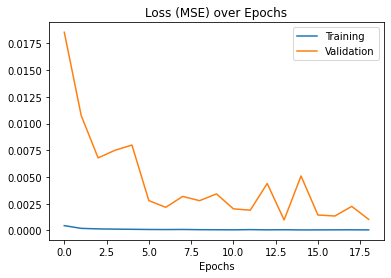

RMSE (Train): 0.28464720337394755
RMSE (Val): 0.782933292773059


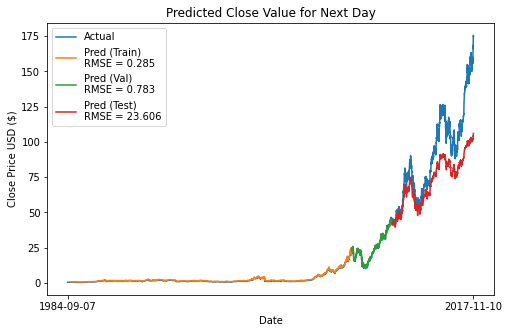

In [13]:
rmse_dd, pred_dd = evaluate_lstm(data_dd, lstm_dd, scaler_dd,
                                 hist=hist_dd, title='Predicted Close Value for Next Day',
                                 actual_data=df, timestep=step, offset=1);

## Next Week Prediction (```t+5```)

In [14]:
data_wk, scaler_wk = train_val_test_split(stock_data, step, split=[0.7,0.1], offset=5)
(xtr, ytr, xval, yval, xts, yts) = data_wk
lstm_wk = build_lstm(timestep=step, nodes=node)
start = time.time()
print('Training...', end=' ')
hist_wk = lstm_wk.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 61.512s


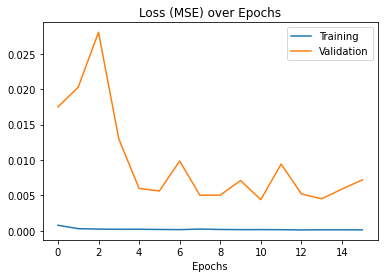

RMSE (Train): 0.3529558234861311
RMSE (Val): 2.063335772478804


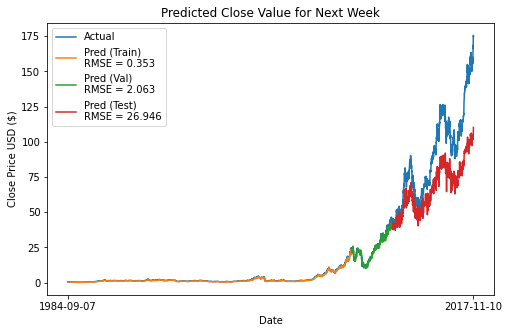

In [15]:
rmse_wk, pred_wk = evaluate_lstm(data_wk, lstm_wk, scaler_wk, 
                                 hist=hist_wk, title='Predicted Close Value for Next Week',
                                 actual_data=df, timestep=step, offset=5, save_fig='wk_norm');

## Next Month Prediction (```t+30```)

In [16]:
data_mm, scaler_mm = train_val_test_split(stock_data, step, split=[0.7,0.1], offset=30)
(xtr, ytr, xval, yval, xts, yts) = data_mm
lstm_mm = build_lstm(timestep=step, nodes=node)
start = time.time()
print('Training...', end=' ')
hist_mm = lstm_mm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 40.012s


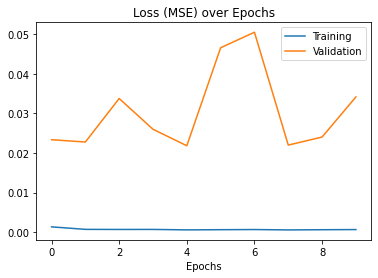

RMSE (Train): 0.6056598234649625
RMSE (Val): 4.497964486822295


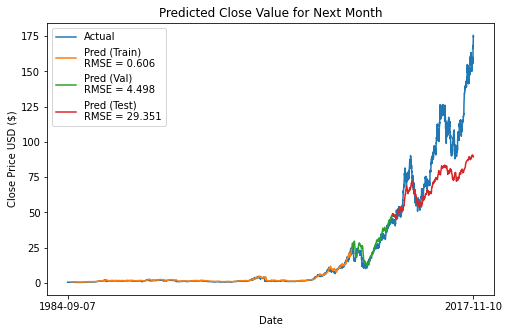

In [17]:
rmse_mm, pred_mm = evaluate_lstm(data_mm, lstm_mm, scaler_mm,
                                 hist=hist_mm, title='Predicted Close Value for Next Month',
                                 actual_data=df, timestep=step, offset=30, save_fig='mm_norm');

## Comparison
We compare the three models by comparing the train, validation and test RMSEs.

In [18]:
compare_df_dict = {
    'Offset': ['t+1', 't+5', 't+30'],
    'RMSE (Train)': [rmse_dd[0], rmse_wk[0], rmse_mm[0]],
    'RMSE (Val)': [rmse_dd[1], rmse_wk[1], rmse_mm[1]],
    'RMSE (Test)': [rmse_dd[2], rmse_wk[2], rmse_mm[2]]
}
compare_df = pd.DataFrame(compare_df_dict)
compare_df.set_index('Offset', inplace=True)
display(compare_df)

,RMSE (Train),RMSE (Val),RMSE (Test)
Offset,,,
t+1,0.284647,0.782933,23.606417
t+5,0.352956,2.063336,26.946286
t+30,0.605660,4.497964,29.351490


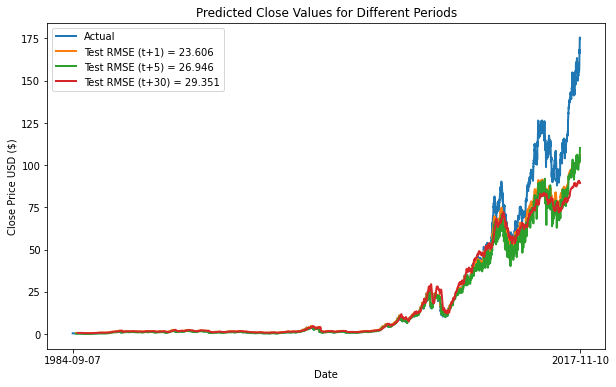

In [19]:
plt.figure(figsize=(10,6))
plt.plot(df['Close'], linewidth=2, label='Actual')
plt.plot(df.index.values[step:], np.r_[pred_dd[0],pred_dd[1],pred_dd[2]], linewidth=2, label='Test RMSE (t+1) = %.3f' % rmse_dd[2])
plt.plot(df.index.values[step+4:], np.r_[pred_wk[0],pred_wk[1],pred_wk[2]], linewidth=2, label='Test RMSE (t+5) = %.3f' % rmse_wk[2])
plt.plot(df.index.values[step+29:], np.r_[pred_mm[0],pred_mm[1],pred_mm[2]], linewidth=2, label='Test RMSE (t+30) = %.3f' % rmse_mm[2])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.title('Predicted Close Values for Different Periods')
plt.legend()
# plt.savefig('compare', transparent=True)
plt.show()

The ```t+1``` model (orange) has the lowest test RMSE and appears to conform to the actual data (blue) most closely, and the ```t+30``` model (red) appears to have trouble predicting rapidly increasing ```Close``` values. Overall, the LSTM models trained on normal (non-stationary) data perform more poorly on periods where the ```Close``` values are changing most rapidly. This is to be expected as the models were trained on the first 70% of the data, which increases at a much slower pace.

To improve model performance, we make the data stationary to eliminate the effect of seasonality and large changes.

# 4. Regression Model for Diff Time Periods (Stationary)
In this section, we train the LSTM models on stationary data, which is achieved through first-order differencing, like for the ARIMA model in *ARIMA.ipynb*.

In [20]:
stationary_data = (df['Close'].values)[1:] - (df['Close'].values)[:-1] # remove seasonality

## Next Day Prediction (Stationary) (```t+1```)

In [21]:
sdata_dd, sscaler_dd = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=1, stationary=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_dd
slstm_dd = build_lstm(timestep=step, nodes=node)
start = time.time()
print('Training...', end=' ')
shist_dd = slstm_dd.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 105.405s


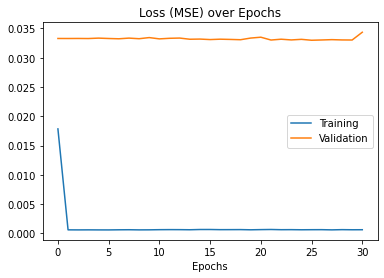

RMSE (Train): 0.11710947945109774
RMSE (Val): 0.4221290859456157


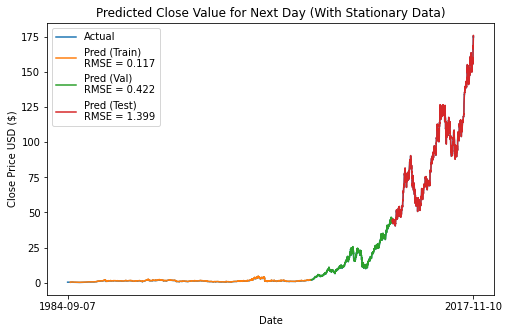

In [22]:
srmse_dd, spred_dd = evaluate_lstm(sdata_dd, slstm_dd, sscaler_dd, stationary=True,
                                   hist=shist_dd, title='Predicted Close Value for Next Day (With Stationary Data)',
                                   actual_data=df, timestep=step, offset=1);

## Next Week Prediction (Stationary) (```t+5```)

In [23]:
sdata_wk, sscaler_wk = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=5, stationary=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_wk
slstm_wk = build_lstm(timestep=step, nodes=node) # Build LSTM model
start = time.time()
print('Training...', end=' ')
shist_wk = slstm_wk.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 134.147s


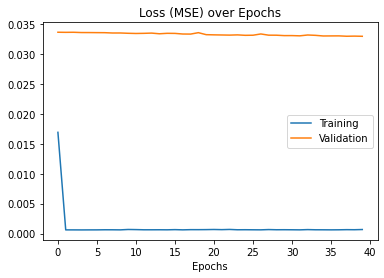

RMSE (Train): 0.06147441807110683
RMSE (Val): 0.4134903865130298


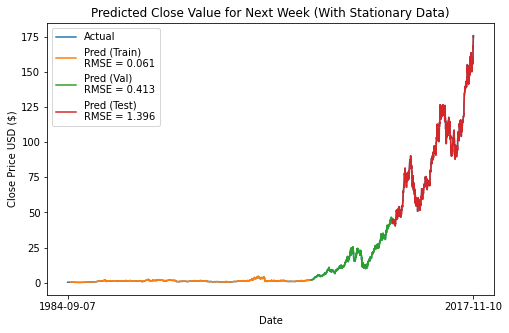

In [24]:
srmse_wk, spred_wk = evaluate_lstm(sdata_wk, slstm_wk, sscaler_wk, stationary=True,
                                  hist=shist_wk, title='Predicted Close Value for Next Week (With Stationary Data)',
                                  actual_data=df, timestep=step, offset=5);

## Next Month Prediction (Stationary) (```t+30```)

In [25]:
sdata_mm, sscaler_mm = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=30, stationary=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_mm
slstm_mm = build_lstm(timestep=step, nodes=node) # Build LSTM model
start = time.time()
print('Training...', end=' ')
shist_mm = slstm_mm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 131.377s


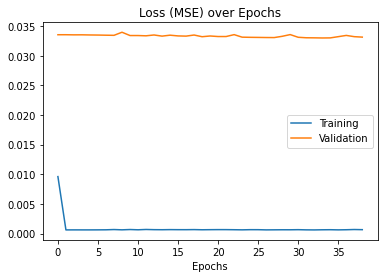

RMSE (Train): 0.05615798466242393
RMSE (Val): 0.41460440184915265


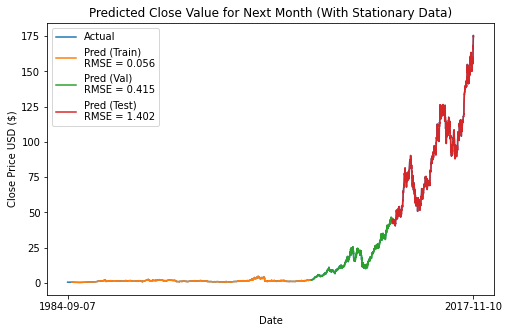

In [26]:
srmse_mm, spred_mm = evaluate_lstm(sdata_mm, slstm_mm, sscaler_mm, stationary=True,
                                   hist=shist_mm, title='Predicted Close Value for Next Month (With Stationary Data)',
                                   actual_data=df, timestep=step, offset=30);

## Comparison (With Models trained on Normal & Stationary Data)
We do a comparison of the train, validation and test RMSEs for all six models - 3 models trained on normal data, and 3 models trained on stationary data.

In [27]:
compare_df['RMSE (Train/Stat)'] = [srmse_dd[0], srmse_wk[0], srmse_mm[0]]
compare_df['RMSE (Val/Stat)'] = [srmse_dd[1], srmse_wk[1], srmse_mm[1]]
compare_df['RMSE (Test/Stat)'] = [srmse_dd[2], srmse_wk[2], srmse_mm[2]]
display(compare_df)

,RMSE (Train),RMSE (Val),RMSE (Test),RMSE (Train/Stat),RMSE (Val/Stat),RMSE (Test/Stat)
Offset,,,,,,
t+1,0.284647,0.782933,23.606417,0.117109,0.422129,1.398614
t+5,0.352956,2.063336,26.946286,0.061474,0.413490,1.396474
t+30,0.605660,4.497964,29.351490,0.056158,0.414604,1.401882


The models trained on stationary data show a massive improvement in performance, with a 10x decrease in RMSEs. Hence, the subsequent models will be trained on stationary data.

# 5. Prediction of Up/Down Trend
In this section, we converted the predicted regression values to predicted classifications of "up" or "down".

In [28]:
# Return the actual and predicted trend values for classification metrics
# Also computes expected gain
def classify(df, pred, offset):
    test_len = len(pred)
    diff = (df['t+%d'%offset].values - df['Close'].values)[-test_len-offset:-offset]
    actual_trend = np.where(diff>0, 1, 0)
    pred_trend = np.where(pred - df['Close'].values[-test_len-offset:-offset]>0, 1, 0)
    total_mg = (diff @ actual_trend)
    total_eg = (diff @ pred_trend)
    mg = total_mg / list(actual_trend).count(1)
    eg = total_eg/list(pred_trend).count(1) if list(pred_trend).count(1)>0 else 0
    return (actual_trend, pred_trend), (eg, mg), (total_eg, total_mg)

We first look at the confusion matrices of the six models.

In [29]:
preds = [pred_dd, pred_wk, pred_mm, spred_dd, spred_wk, spred_mm]
trend_true, trend_pred = [[] for k in range(6)], [[] for k in range(6)]
gains, total_gains = [[] for k in range(6)], [[] for k in range(6)]

# ×6 for dd,wk,mm for normal and stationary data
for i in range(6): 
    offset = [1,5,30][i%3]
    trends, gain, total_gain = classify(df, preds[i][2], offset)
    trend_true[i], trend_pred[i] = trends[0], trends[1]
    gains[i] = gain
    total_gains[i] = total_gain
    
metrics_dict = {
    'Accuracy':[],
    'Precision':[],
    'Recall':[],
    'F1 Score':[]
} 

print('Confusion Matrices for each Model:')
for i in range(6):
    metrics_dict['Accuracy'].append(accuracy_score(trend_true[i], trend_pred[i]))
    metrics_dict['Precision'].append(precision_score(trend_true[i], trend_pred[i], zero_division=0))
    metrics_dict['Recall'].append(recall_score(trend_true[i], trend_pred[i], zero_division=0))
    metrics_dict['F1 Score'].append(f1_score(trend_true[i], trend_pred[i]))
    tn, fp, fn, tp = confusion_matrix(trend_true[i], trend_pred[i]).ravel()
    cmat = pd.DataFrame({'':['Pred Up','Pred Down'], 'Actual Up':[tp,fn], 'Actual Down':[fp,tn]})
    cmat.set_index('', inplace=True)
    print(['Day:','\nWeek:','\nMonth:', 'Day (Stat):','\nWeek (Stat):','\nMonth (Stat):'][i])
    display(cmat)

Confusion Matrices for each Model:
Day:


,Actual Up,Actual Down
,,
Pred Up,0,0
Pred Down,869,804



Week:


,Actual Up,Actual Down
,,
Pred Up,0,0
Pred Down,934,739



Month:


,Actual Up,Actual Down
,,
Pred Up,190,94
Pred Down,816,573


Day (Stat):


,Actual Up,Actual Down
,,
Pred Up,759,699
Pred Down,110,105



Week (Stat):


,Actual Up,Actual Down
,,
Pred Up,827,118
Pred Down,107,621



Month (Stat):


,Actual Up,Actual Down
,,
Pred Up,961,36
Pred Down,45,631


Like evaluation with RMSE, we observe the models trained on non-stationary data to have much worse prediction of trends. The ```t+1``` and ```t+5``` models trained on normal data even had no true positives, hence traders using these models will never buy.

In [30]:
metric_df = pd.DataFrame({k:v[:3] for k,v in metrics_dict.items()})
metric_df['Offset'] = compare_df.index.values
metric_df.set_index('Offset', inplace=True)
for metric in metrics_dict:
    metric_df[metric+' (Stat)'] = metrics_dict[metric][3:]
display(compare_df)
display(metric_df)

,RMSE (Train),RMSE (Val),RMSE (Test),RMSE (Train/Stat),RMSE (Val/Stat),RMSE (Test/Stat)
Offset,,,,,,
t+1,0.284647,0.782933,23.606417,0.117109,0.422129,1.398614
t+5,0.352956,2.063336,26.946286,0.061474,0.413490,1.396474
t+30,0.605660,4.497964,29.351490,0.056158,0.414604,1.401882


,Accuracy,Precision,Recall,F1 Score,Accuracy (Stat),Precision (Stat),Recall (Stat),F1 Score (Stat)
Offset,,,,,,,,
t+1,0.480574,0.000000,0.000000,0.000000,0.516438,0.520576,0.873418,0.652342
t+5,0.441721,0.000000,0.000000,0.000000,0.865511,0.875132,0.885439,0.880255
t+30,0.456067,0.669014,0.188867,0.294574,0.951584,0.963892,0.955268,0.959561


We do a final comparison of classification scores, and once again, the models trained on stationary data have much better overall performance. 

For models trained on normal data, while the ```t+1``` model has lowest RMSE, it has terrible precision, which renders it useless.

For models trained on stationary data, the ```t+5``` model has the lowest RMSE, but the ```t+30``` model does better in prediction of trends. Since performance on regression and classification have contrasting results, we look at expected gain in the next section to conclude on the best model.

# 6. Expected Gain
In this section, we compare the expected gains per trade of the different models.

In [31]:
for i in range(3):
    print('Expected Gain ' + ['(t+1):','(t+5):','(t+30):'][i], end=' ')
    print('%.3g, %.3f (Stationary)' % (gains[i][0], gains[i+3][0]))
print()    
for i in range(3):
    print('Optimal Gain ' + ['(t+1):','(t+5):','(t+30):'][i], end=' ')
    print('%.3f' % gains[i][1])

Expected Gain (t+1): 0, 0.080 (Stationary)
Expected Gain (t+5): 0, 2.240 (Stationary)
Expected Gain (t+30): 2.61, 7.036 (Stationary)

Optimal Gain (t+1): 1.017
Optimal Gain (t+5): 2.488
Optimal Gain (t+30): 7.051


We see here that the optimal gain (assuming a 100% accuracy of prediction of trends) varies with different time offsets, which is to be expected as the Apple stock is of an increasing trend, hence the close value one month later is likely to be much higher than the close value one day later.

To compare the expected gains between different time offsets, we thus find the percentage expected gain. This is computed by dividing the total expected gain (expected gain before dividing by number of trades) by the total optimal gain (which is the maximum amount the trader can earn). The cell below shows the percentage expected gains of the three models trained on stationary data.

In [32]:
for i in range(3):
    pgain = total_gains[i+3][0]/total_gains[i+3][1]
    print('% Gain ' + ['(t+1):','(t+5):','(t+30):'][i], end=' ')
    print('%.2f' % (pgain*100) + "%", end=' ')
    print('(%.2f/%.2f)' % (total_gains[i+3][0],total_gains[i+3][1]))

% Gain (t+1): 13.13% (116.06/883.89)
% Gain (t+5): 91.09% (2116.97/2324.10)
% Gain (t+30): 98.89% (7014.93/7093.55)


By comparing the percentage expected gain, we can conclude that the ```t+30``` model is best for the Apple stock. However, as stated earlier, this is to be expected as the Apple stock is of an increasing trend. We thus need to compare the expected gains of models trained on stocks with different price patterns to truly evaluate the models.

# 7. Different Stocks
In this section, we train models for different stocks with different price trends: 1. Increasing (AAPL), 2. Fluctuating (MIK) and 3. Decreasing (YPF). From the earlier sections, we found that stationary data improved performance, hence we will process the data to make it stationary, and train the models to predict the ```Close``` value for the next day (```t+1```), week (```t+5```) and month (```t+30```).

In [33]:
stocks = ['aapl','mik','ypf']

In [34]:
# This function condenses the generation of datasets and training & prediction models
# Returns a dictionary with the data and trained model
def train_diff_stocks(z):
    diff_stocks = {'vars':{},'model':{}}
    
    for stock in stocks:

        # Import stock data
        df = pd.read_csv('%s.us.txt' % stock, index_col=0)
        stock_data = df['Close'].values
        stationary_data = (df['Close'].values)[1:] - (df['Close'].values)[:-1] # remove seasonality

        # Generate dataset
        data, scaler = train_val_test_split(stock_data, step, split=[0.6,0.2], offset=z)
        sdata, sscaler = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=z, stationary=True)
        (xtr, ytr, xval, yval, xts, yts) = sdata

        # Training & prediction
        lstm = build_lstm(timestep=step, nodes=node)
        start = time.time()
        print('Training (%s)...' % stock, end=' ')
        lstm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
        end = time.time()
        print('Done. Time taken: %.3fs' % (end-start))

        diff_stocks['vars'][stock] = (df, data, scaler, sdata, sscaler)
        diff_stocks['model'][stock] = lstm
        
    return diff_stocks

In [35]:
# Evaluates the given trained model and stores the metrics in the given dictionary
def evaluate_diff_stocks(diff_stocks, stocks, offset, show_plot=1, save_fig=False):
    
    if 'rmse' not in diff_stocks:
        metrics = ['rmse','acc','rec','prc','f1','gain','opt_gain','pgain']
        for metric in metrics:
            diff_stocks[metric] = {}
    
    for stock in stocks:
        df = diff_stocks['vars'][stock][0]
        data, scaler = diff_stocks['vars'][stock][1], diff_stocks['vars'][stock][2]
        sdata, sscaler = diff_stocks['vars'][stock][3], diff_stocks['vars'][stock][4]
        model = diff_stocks['model'][stock]
        
        # Add columns for offsets
        df['t+1'] = np.r_[df['Close'].values[1:], np.nan]
        df['t+5'] = np.r_[df['Close'].values[5:], np.empty((5,))*np.nan]
        df['t+30'] = np.r_[df['Close'].values[30:], np.empty((30,))*np.nan]
        
        # Get RMSE and Predicted Values
        rmse, pred = evaluate_lstm(sdata, model, sscaler, stationary=True,
                                   show_loss=0, show_plot=show_plot, title='Predicted Close Values for Next Month',
                                   actual_data=df, timestep=step, offset=offset, stock=stock, save_fig=save_fig);
        
        # Find Accuracy, Precision, Recall, F1, Expected Gain
        trends, gain, total_gain = classify(df, pred[2], offset)
        trend_true, trend_pred = trends[0], trends[1]

        # Store Metrics
        diff_stocks['rmse'][stock] = [v for v in rmse]
        diff_stocks['acc'][stock] = accuracy_score(trend_true, trend_pred)
        diff_stocks['prc'][stock] = precision_score(trend_true, trend_pred, zero_division=0)
        diff_stocks['rec'][stock] = recall_score(trend_true, trend_pred, zero_division=0)
        diff_stocks['f1'][stock] = f1_score(trend_true, trend_pred)
        diff_stocks['pgain'][stock] = total_gain[0]/total_gain[1]
        diff_stocks['gain'][stock] = gain[0]
        diff_stocks['opt_gain'][stock] = gain[1]
    
    return diff_stocks

In [36]:
# Returns a DataFrame for easier comparison of different evaluation metrics of different models
def compare_diff_stocks(diff_stocks):
    
    stocks = diff_stocks['model'].keys()
    compare_diff_stocks_dict = {'Stock': stocks}
    
    metrics = ['RMSE (Train)','RMSE (Val)','RMSE (Test)','Accuracy','Precision','Recall','F1 Score','% Gain','Expected Gain']
    for metric in metrics:
        compare_diff_stocks_dict[metric] = []
        
    for stock in stocks:
        compare_diff_stocks_dict['RMSE (Train)'].append(diff_stocks['rmse'][stock][0])
        compare_diff_stocks_dict['RMSE (Val)'].append(diff_stocks['rmse'][stock][1])
        compare_diff_stocks_dict['RMSE (Test)'].append(diff_stocks['rmse'][stock][2])
        compare_diff_stocks_dict['Accuracy'].append(diff_stocks['acc'][stock])
        compare_diff_stocks_dict['Precision'].append(diff_stocks['prc'][stock])
        compare_diff_stocks_dict['Recall'].append(diff_stocks['rec'][stock])
        compare_diff_stocks_dict['F1 Score'].append(diff_stocks['f1'][stock])
        compare_diff_stocks_dict['Expected Gain'].append(diff_stocks['gain'][stock])
        compare_diff_stocks_dict['% Gain'].append(diff_stocks['pgain'][stock])
        
    compare_diff_stocks_df = pd.DataFrame(compare_diff_stocks_dict)
    compare_diff_stocks_df.set_index('Stock', inplace=True)
    return compare_diff_stocks_df

## Next Month
Train models for the three stocks with a time offset of ```t+30```.

In [37]:
diff30 = train_diff_stocks(30)

Training (aapl)... Done. Time taken: 135.552s
Training (mik)... Done. Time taken: 7.725s
Training (ypf)... Done. Time taken: 14.512s


INCREASING


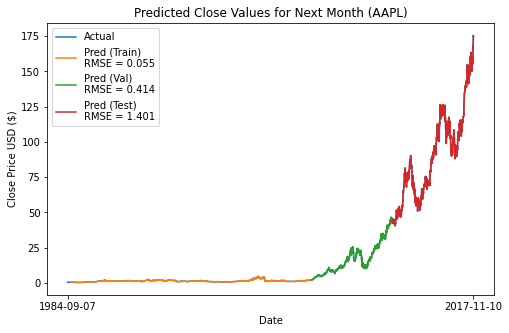

UP & DOWN


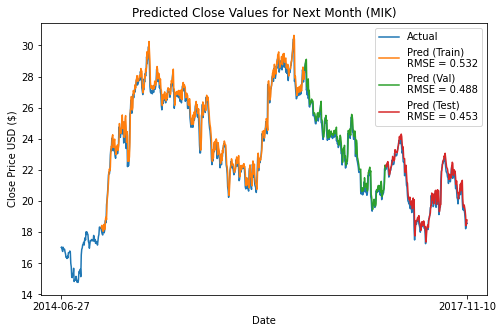

DOWN


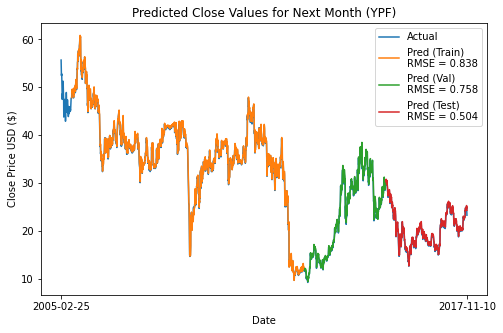

In [44]:
print('INCREASING')
diff30 = evaluate_diff_stocks(diff30, ['aapl'], offset=30) # save_fig='aapl'
print('UP & DOWN')
diff30 = evaluate_diff_stocks(diff30, ['mik'], offset=30) # save_fig='mik'
print('DOWN')
diff30 = evaluate_diff_stocks(diff30, ['ypf'], offset=30) # save_fig='ypf'

In [45]:
df30 = compare_diff_stocks(diff30)
display(df30)

,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Gain,Expected Gain
Stock,,,,,,,,,
aapl,0.055163,0.414117,1.401194,0.950986,0.962926,0.955268,0.959082,0.988824,7.028330
mik,0.531856,0.487790,0.453112,0.988304,0.979592,1.000000,0.989691,0.993927,1.837041
ypf,0.838090,0.757820,0.504151,0.959375,0.950178,0.956989,0.953571,0.991226,2.414961


## Next Day (```t+1```)
Train models for the three stocks with a time offset of ```t+1```.

In [46]:
diff1 = train_diff_stocks(1)

Training (aapl)... Done. Time taken: 126.294s
Training (mik)... Done. Time taken: 7.621s
Training (ypf)... Done. Time taken: 31.011s


In [47]:
diff1 = evaluate_diff_stocks(diff1, stocks, offset=1, show_plot=0)
df1 = compare_diff_stocks(diff1)
display(df1)

,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Gain,Expected Gain
Stock,,,,,,,,,
aapl,0.064258,0.416949,1.402782,0.515242,0.539402,0.456847,0.494704,0.098232,0.117971
mik,0.493607,0.459049,0.402956,0.532164,0.528302,0.943820,0.677419,-0.129969,-0.018302
ypf,0.838848,0.760231,0.511751,0.470313,0.470313,1.000000,0.639745,-0.060472,-0.010541


## Next Week (```t+5```)
Train models for the three stocks with a time offset of ```t+5```.

In [48]:
diff5 = train_diff_stocks(5)

Training (aapl)... Done. Time taken: 150.537s
Training (mik)... Done. Time taken: 9.713s
Training (ypf)... Done. Time taken: 28.678s


In [49]:
diff5 = evaluate_diff_stocks(diff5, stocks, offset=5, show_plot=0)
df5 = compare_diff_stocks(diff5)
display(df5)

,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,% Gain,Expected Gain
Stock,,,,,,,,,
aapl,0.055631,0.413188,1.396737,0.866109,0.879274,0.881156,0.880214,0.913925,2.269290
mik,0.492628,0.447602,0.389807,0.871345,0.871795,0.850000,0.860759,0.859665,0.592949
ypf,0.840480,0.778293,0.517455,0.840625,0.912134,0.729097,0.810409,0.891921,0.995234


## Comparison of Models for Different Stocks
We do a final comparison of the most important metrics for models for each stock - RMSE (test), precision and expected gain.

In [51]:
compare_impt_dict = {
    'Stock': stocks*3,
    'Offset': ['t+1']*3 + ['t+5']*3 + ['t+30']*3,
    'RMSE': [],
    'Precision': [],
    'Gain': [], 
    '% Gain': []
}
for df in [df1,df5,df30]:
    for stock in stocks:
        compare_impt_dict['RMSE'].append(df['RMSE (Test)'][stock])
        compare_impt_dict['Precision'].append(df['Precision'][stock])
        compare_impt_dict['Gain'].append(df['Expected Gain'][stock])
        compare_impt_dict['% Gain'].append(df['% Gain'][stock])
compare_impt = pd.DataFrame(compare_impt_dict)
compare_impt.set_index('Stock', inplace=True)
compare_impt.sort_values('Stock', inplace=True)
display(compare_impt.drop('Gain', axis=1))

,Offset,RMSE,Precision,% Gain
Stock,,,,
aapl,t+1,1.402782,0.539402,0.098232
aapl,t+5,1.396737,0.879274,0.913925
aapl,t+30,1.401194,0.962926,0.988824
mik,t+1,0.402956,0.528302,-0.129969
mik,t+5,0.389807,0.871795,0.859665
mik,t+30,0.453112,0.979592,0.993927
ypf,t+1,0.511751,0.470313,-0.060472
ypf,t+5,0.517455,0.912134,0.891921
ypf,t+30,0.504151,0.950178,0.991226


We sort the above DataFrame by stock to better compare between different time offsets. For this comparison, we look at the percentage expected gain as each time offset has different optimal gains. Across different stock trends, we see that model performance increase with offset, with the ```t+30``` models achieving highest gain and precision whether stock prices are increasing, fluctuating or decreasing.

In [52]:
compare_impt.drop('% Gain', axis=1).sort_values(by=['Offset'], key=lambda x:x.map({'t+1':0,'t+5':1,'t+30':2}))

,Offset,RMSE,Precision,Gain
Stock,,,,
aapl,t+1,1.402782,0.539402,0.117971
mik,t+1,0.402956,0.528302,-0.018302
ypf,t+1,0.511751,0.470313,-0.010541
aapl,t+5,1.396737,0.879274,2.269290
mik,t+5,0.389807,0.871795,0.592949
ypf,t+5,0.517455,0.912134,0.995234
aapl,t+30,1.401194,0.962926,7.028330
mik,t+30,0.453112,0.979592,1.837041
ypf,t+30,0.504151,0.950178,2.414961


We re-sort the DataFrame by offset to easily compare between different stock trends. For this comparison, we look at the expected gain instead of percentage expected gain to compare the amounts the user can earn from each stock. As expected, the model trained on the increasing Apple stock has the highest gains across different offsets. However, interestingly, despite the YPF stock being the decreasing stock, the ```t+5``` and ```t+30``` models for YPF have higher gain than the models for MIK.